In [1]:
import pandas as pd
import geopandas as gpd
import json
from pystac_client import Client
from copy import deepcopy
from shapely.geometry import shape

# convert a list of STAC Items into a GeoDataFrame
def items_to_geodataframe(items):
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

In [2]:

URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
print(cat)

collections = [(c.id, c.title) for c in cat.get_collections()]
pd.set_option("display.max_colwidth", 150)
df = pd.DataFrame(collections, columns=['id', 'title'])
df

<Client id=stac-server>


id  \
0   landsat-c1l2alb-st   
1      landsat-c2l2-sr   
2      landsat-c2l2-st   
3     landsat-c2ard-st   
4   landsat-c2l2alb-bt   
5     landsat-c2ard-bt   
6    landsat-c2l3-fsca   
7   landsat-c1l2alb-bt   
8         landsat-c2l1   
9      landsat-c2l3-ba   
10  landsat-c1l2alb-ta   
11  landsat-c2l2alb-st   
12    landsat-c2ard-sr   
13        landsat-c1l1   
14  landsat-c1l2alb-sr   
15  landsat-c2l2alb-ta   
16  landsat-c2l2alb-sr   
17    landsat-c2ard-ta   
18   landsat-c2l3-dswe   

                                                                                                               title  
0                                               Landsat Collection 1 Level-2 Albers Surface Temperature (ST) Product  
1                                                  Landsat Collection 2 Level-2 UTM Surface Reflectance (SR) Product  
2                                                  Landsat Collection 2 Level-2 UTM Surface Temperature (ST) Product  
3                        Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Temperature (ST) Product  
4                          Landsat Collection 2 Level-2 Albers Top of Atmosphere Brightness Temperature (BT) Product  
5   Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Top of Atmosphere Brightness Temperature (BT) Product  
6                                           Landsat Collection 2 Level-3 Fractional Snow Covered Area (fSCA) Product  
7                          Landsat Collection 1 Level-2 Albers Top of Atmosphere Brightness Temperature (BT) Product  
8                                                                               Landsat Collection 2 Level-1 Product  
9                                                              Landsat Collection 2 Level-3 Burned Area (BA) Product  
10                                    Landsat Collection 1 Level-2 Albers Top of Atmosphere (TA) Reflectance Product  
11                                              Landsat Collection 2 Level-2 Albers Surface Temperature (ST) Product  
12                       Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Reflectance (SR) Product  
13                                                                              Landsat Collection 1 Level-1 Product  
14                                              Landsat Collection 1 Level-2 Albers Surface Reflectance (SR) Product  
15                                    Landsat Collection 2 Level-2 Albers Top of Atmosphere (TA) Reflectance Product  
16                                              Landsat Collection 2 Level-2 Albers Surface Reflectance (SR) Product  
17             Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Top of Atmosphere (TA) Reflectance Product  
18                                          Landsat Collection 2 Level-3 Dynamic Surface Water Extent (DSWE) Product

In [3]:
collection_id = 'landsat-c2l2-st'
aoi = gpd.read_file('./bear-fire.geojson')
geom = json.loads(aoi['geometry'].to_json())['features'][0]['geometry']

# limit sets the # of items per page so we can see multiple pages getting fetched
search = cat.search(
    collections = [collection_id],
    intersects = aoi['geometry'][0],
    datetime = "2021-01-01/2021-03-31",
    query = ["eo:cloud_cover<10"],
    limit = 100
)

# Get all items as a dictionary
items_dict = search.get_all_items_as_dict()['features']

# update URLs to use s3
for item in items_dict:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')

# items_dict

In [4]:

# Create GeoDataFrame from Items
items_gdf = items_to_geodataframe(items_dict)

print(f"{len(items_dict)} items found")

pd.reset_option("display.max_colwidth")
items_gdf#['assets.lwir11.alternate.s3.href']

12 items found


type stac_version  \
properties.datetime                                      
2021-03-29 17:57:33.490812+00:00  Feature        1.0.0   
2021-03-29 17:57:09.605839+00:00  Feature        1.0.0   
2021-03-21 18:45:29.657317+00:00  Feature        1.0.0   
2021-03-21 18:45:05.774750+00:00  Feature        1.0.0   
2021-03-13 17:58:50.920048+00:00  Feature        1.0.0   
2021-03-13 17:58:27.036354+00:00  Feature        1.0.0   
2021-03-05 18:45:37.619485+00:00  Feature        1.0.0   
2021-03-05 18:45:13.732681+00:00  Feature        1.0.0   
2021-02-17 18:45:44.690094+00:00  Feature        1.0.0   
2021-02-17 18:45:20.803291+00:00  Feature        1.0.0   
2021-01-16 18:45:50.467085+00:00  Feature        1.0.0   
2021-01-16 18:45:26.576045+00:00  Feature        1.0.0   

                                                                    stac_extensions  \
properties.datetime                                                                   
2021-03-29 17:57:33.490812+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-29 17:57:09.605839+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-21 18:45:29.657317+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-21 18:45:05.774750+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-13 17:58:50.920048+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-13 17:58:27.036354+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-05 18:45:37.619485+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-03-05 18:45:13.732681+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-02-17 18:45:44.690094+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-02-17 18:45:20.803291+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-01-16 18:45:50.467085+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   
2021-01-16 18:45:26.576045+00:00  [https://landsat.usgs.gov/stac/landsat-extensi...   

                                                                           id  \
properties.datetime                                                             
2021-03-29 17:57:33.490812+00:00  LE07_L2SP_044033_20210329_20210424_02_T1_ST   
2021-03-29 17:57:09.605839+00:00  LE07_L2SP_044032_20210329_20210424_02_T1_ST   
2021-03-21 18:45:29.657317+00:00  LC08_L2SP_044033_20210321_20210401_02_T1_ST   
2021-03-21 18:45:05.774750+00:00  LC08_L2SP_044032_20210321_20210401_02_T1_ST   
2021-03-13 17:58:50.920048+00:00  LE07_L2SP_044033_20210313_20210410_02_T1_ST   
2021-03-13 17:58:27.036354+00:00  LE07_L2SP_044032_20210313_20210410_02_T1_ST   
2021-03-05 18:45:37.619485+00:00  LC08_L2SP_044033_20210305_20210312_02_T1_ST   
2021-03-05 18:45:13.732681+00:00  LC08_L2SP_044032_20210305_20210312_02_T1_ST   
2021-02-17 18:45:44.690094+00:00  LC08_L2SP_044033_20210217_20210302_02_T1_ST   
2021-02-17 18:45:20.803291+00:00  LC08_L2SP_044032_20210217_20210302_02_T1_ST   
2021-01-16 18:45:50.467085+00:00  LC08_L2SP_044033_20210116_20210306_02_T1_ST   
2021-01-16 18:45:26.576045+00:00  LC08_L2SP_044032_20210116_20210306_02_T1_ST   

                                                                        description  \
properties.datetime                                                                   
2021-03-29 17:57:33.490812+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-29 17:57:09.605839+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-21 18:45:29.657317+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-21 18:45:05.774750+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-13 17:58:50.920048+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-13 17:58:27.036354+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-05 18:45:37.619485+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   
2021-03-05 18:45:13.732681+00:00  Landsat Collection 2 Level-2 Surface Temperatu...   


In [5]:
# items_gdf['assets.lwir11.alternate.s3.href'].values

In [6]:
import hvplot.pandas

def plot_polygons(data, *args, **kwargs):
    return data.hvplot.paths(*args, geo=True, tiles='OSM', xaxis=None, yaxis=None,
                             frame_width=600, frame_height=600,
                             line_width=3, **kwargs)

plot_polygons(aoi) * items_gdf.hvplot.paths(geo=True)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]
   .Path.II :Path   [Longitude,Latitude]

In [7]:
import yaml

cfg = """---
landsat-c2l2-st:
  measurements:
    '*':
      dtype: uint16
      nodata: 0
      unit: 'm'
"""
cfg = yaml.load(cfg, Loader=yaml.CSafeLoader)

In [8]:
%%time
import stackstac
import pystac
from odc.stac import stac_load
from pyproj import CRS


# Create PySTAC ItemCollection
# item_collection = pystac.ItemCollection(items_dict[-2:])

item_collection = pystac.ItemCollection(items_dict)


# %time stack = stackstac.stack(item_collection, epsg=CRS(('epsg', 4326)))
%time stack = stackstac.stack(item_collection, epsg=CRS(('epsg', 32610)))

CPU times: user 620 ms, sys: 35.8 ms, total: 655 ms
Wall time: 1.77 s
CPU times: user 1.23 s, sys: 181 ms, total: 1.41 s
Wall time: 2.79 s


In [9]:
# lowcloud = stack[stack["eo:cloud_cover"] < 20]
# rgb = lowcloud.sel(band=["B04", "B03", "B02"])
lst = stack.sel({'band':'lwir11'})
monthly = lst.resample(time="MS").median("time", keep_attrs=True)

In [10]:
# dir(item_collection[0])
item_collection[0].properties

{'datetime': '2021-03-29T17:57:33.490812Z',
 'eo:cloud_cover': 0,
 'view:sun_azimuth': 130.53782366,
 'view:sun_elevation': 43.38653299,
 'platform': 'LANDSAT_7',
 'instruments': ['ETM'],
 'view:off_nadir': 0,
 'landsat:cloud_cover_land': 0,
 'landsat:wrs_type': '2',
 'landsat:wrs_path': '044',
 'landsat:wrs_row': '033',
 'landsat:scene_id': 'LE70440332021088EDC00',
 'landsat:collection_category': 'T1',
 'landsat:collection_number': '02',
 'landsat:correction': 'L2SP',
 'proj:epsg': 32610,
 'proj:shape': [7131, 8151],
 'proj:transform': [30, 0, 478485, 0, -30, 4416615],
 'created': '2021-07-26T07:01:25.971Z',
 'updated': '2021-07-26T07:01:25.971Z'}

In [11]:
from rasterio.session import AWSSession

import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = monthly.compute()

[#############                           ] | 32% Completed | 20.9s

/Users/kevinlalli/miniconda3/envs/odc-stac/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed |  2min 38.0s


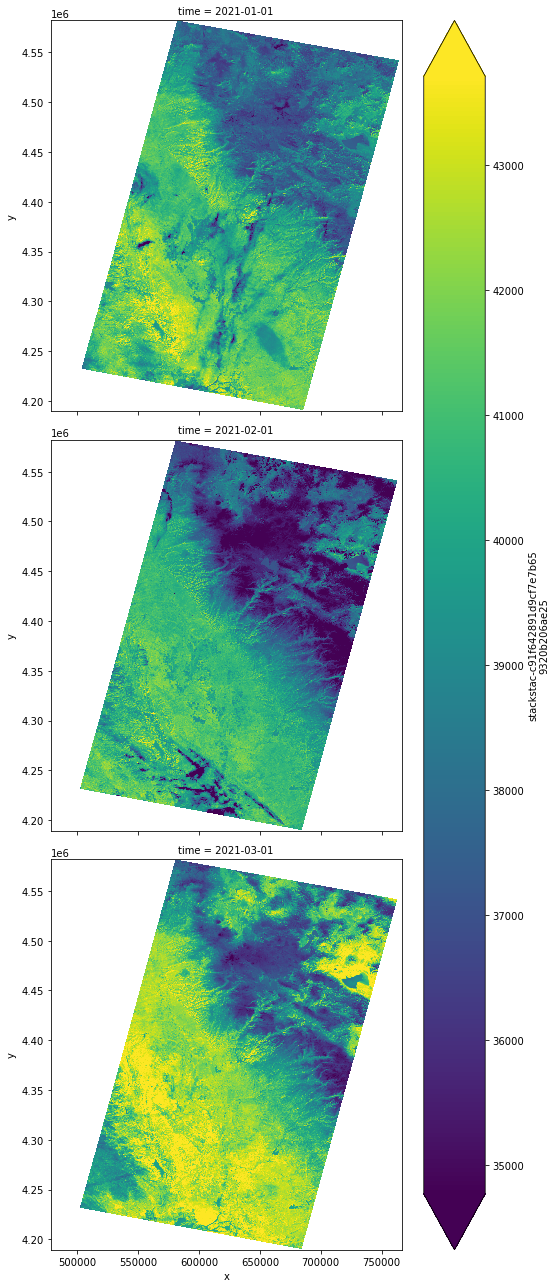

In [12]:
data.plot.imshow(row="time", robust=True, size=6);

In [13]:
data = data*0.00341802 + 149.0

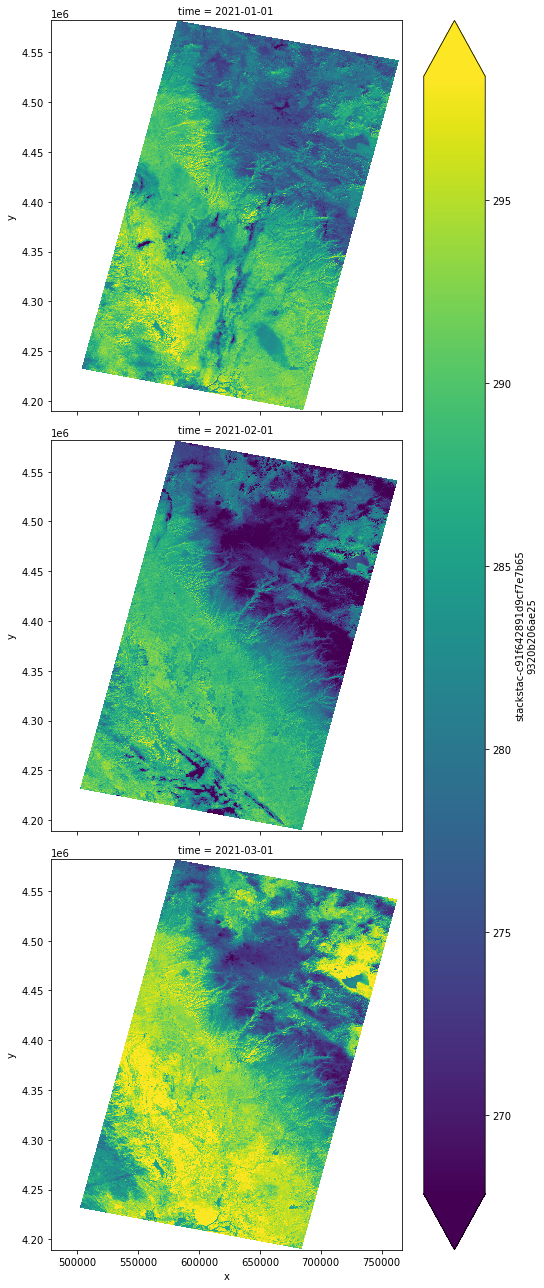

In [14]:
data.plot.imshow(row="time", robust=True, size=6);